In [189]:
import os
from sys import path as syspath
from os import path as ospath

syspath.append(ospath.join(ospath.expanduser("~"), 'CBSA'))

from joblib import Parallel, delayed
import pickle
import gc
import time
from collections import Counter

from cbsa import ReactionSystem
import stochpy as sp
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

In [201]:
from matplotlib import rc
matplotlib.rcParams.update({'text.usetex': True})
matplotlib.rc('text.latex', preamble=r"\usepackage{color}")

matplotlib.rc('pgf', texsystem='pdflatex')  # from running latex -v

plt.style.use("bmh")
plt.rcParams["font.family"] = "serif"
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

In [163]:
def run_cbsa(n_reactions,k0,k1,total_sim_time,dt,alpha=0.5):
    
    S = np.zeros((n_reactions+1,n_reactions+1))
    S[0,0] = 1
    S[0,1:] = np.array([-1 for i in range(n_reactions)])
    S[1:,1:] = np.identity(n_reactions)

    x = [0 for i in range(n_reactions+1)]
    k = [k0]+[k1 for i in range(n_reactions)]

    max_dt = dt
    
    cbsa = ReactionSystem(S)
    cbsa.setup()
    cbsa.set_x(x)
    cbsa.set_k(k)
    
    cbsa.setup_simulation(use_opencl=False,alpha=alpha,max_dt=max_dt)
    time_start = time.clock()
    cbsa.compute_simulation(total_sim_time,batch_steps=1)
    time_elapsed = (time.clock() - time_start)
    cbsa_data = np.array(cbsa.simulation_data)
    
    del cbsa
    
    return time_elapsed,cbsa_data

def run_cbsa_dt1(n_reactions,k0,k1,total_sim_time):
    return run_cbsa(n_reactions,k0,k1,total_sim_time,1.)

def run_cbsa_dt0_1(n_reactions,k0,k1,total_sim_time):
    return run_cbsa(n_reactions,k0,k1,total_sim_time,0.1)

def run_cbsa_dt0_05(n_reactions,k0,k1,total_sim_time):
    return run_cbsa(n_reactions,k0,k1,total_sim_time,0.05)

def run_cbsa_dt0_01(n_reactions,k0,k1,total_sim_time):
    return run_cbsa(n_reactions,k0,k1,total_sim_time,0.01)

def run_cbsa_dt1_alpha_025(n_reactions,k0,k1,total_sim_time):
    return run_cbsa(n_reactions,k0,k1,total_sim_time,1.,alpha=0.25)

def run_cbsa_dt0_1_alpha_025(n_reactions,k0,k1,total_sim_time):
    return run_cbsa(n_reactions,k0,k1,total_sim_time,0.1,alpha=0.25)

def run_cbsa_dt0_05_alpha_025(n_reactions,k0,k1,total_sim_time):
    return run_cbsa(n_reactions,k0,k1,total_sim_time,0.05,alpha=0.25)

def run_cbsa_dt0_01_alpha_025(n_reactions,k0,k1,total_sim_time):
    return run_cbsa(n_reactions,k0,k1,total_sim_time,0.01,alpha=0.25)


def create_psc_model(n_reactions,path="/home/burke/Stochpy/pscmodels/"):
    model_str = ""
    
    model_str += "R0:\n\t$pool > A\n\tk0\n\n"
    
    for i in range(1,n_reactions+1):
        model_str += "R"+str(i)+":\n\tA > B"+str(i)+"\n\tA*k1\n\n"
        
    model_str += "k0 = 1.0\n\n"
    model_str += "k1 = 1.0\n\n"
    
    model_str += "A = 0.0\n"
    for i in range(1,n_reactions+1):
        model_str += "B"+str(i)+" = 0.0\n"
    
    if not os.path.exists(path+"concurrent_reactions"):
        os.makedirs(path+"concurrent_reactions")
    
    model_path = "concurrent_reactions/"+str(n_reactions)+"_concurrent_reactions.psc"
    
    with open(path+model_path,"w") as f:
        f.write(model_str)

    return model_path

def run_sp_ssa(n_reactions,k0,k1,total_sim_time):
    model_path = "concurrent_reactions/"+str(n_reactions)+"_concurrent_reactions.psc"
    smod = sp.SSA()
    smod.Model(model_path)
    smod.ChangeParameter("k0",k0)
    smod.ChangeParameter("k1",k1)
    
    time_start = time.clock()
    smod.DoStochSim(mode='time',end=total_sim_time,trajectories=1)
    time_elapsed = (time.clock() - time_start)
    sp_ssa_data = smod.data_stochsim.getSpecies()
    
    del smod
    
    return time_elapsed,sp_ssa_data

def run_sp_tauleap(n_reactions,k0,k1,total_sim_time):
    model_path = "concurrent_reactions/"+str(n_reactions)+"_concurrent_reactions.psc"
    smod = sp.SSA()
    smod.Model(model_path)
    smod.ChangeParameter("k0",k0)
    smod.ChangeParameter("k1",k1)    
    
    time_start = time.clock()
    smod.DoStochSim(method='Tauleap',mode='time',end=total_sim_time,trajectories=1)
    time_elapsed = (time.clock() - time_start)
    sp_tauleap_data = smod.data_stochsim.getSpecies()
    
    del smod
    
    return time_elapsed,sp_tauleap_data

def run_simulation(info):
    functions = {"CBSA dt 1.0":run_cbsa_dt1,
                 "CBSA dt 0.1":run_cbsa_dt0_1,
                 "CBSA dt 0.05":run_cbsa_dt0_05,
                 "CBSA dt 0.01":run_cbsa_dt0_01,
                 "CBSA dt 1.0 alpha 0.25":run_cbsa_dt1_alpha_025,
                 "CBSA dt 0.1 alpha 0.25":run_cbsa_dt0_1_alpha_025,
                 "CBSA dt 0.05 alpha 0.25":run_cbsa_dt0_05_alpha_025,
                 "CBSA dt 0.01 alpha 0.25":run_cbsa_dt0_01_alpha_025,
                 "StochPy SSA":run_sp_ssa,
                 "StochPy Tauleap":run_sp_tauleap,
                }
    method = info[0]
    replicates = info[1]
    param = info[2]
    function = functions[method]
    data = [function(*param) for i in range(replicates)]
    n_reactions = param[0]
    k0 = param[1]
    k1 = param[2]
    if not os.path.exists("concurrent_reactions_"+str(k0)+"_"+str(k1)):
        os.makedirs("concurrent_reactions_"+str(k0)+"_"+str(k1))
    with open("concurrent_reactions_"+str(k0)+"_"+str(k1)+"/"+method.replace(" ","_")+"_"+str(n_reactions)+"_concurrent_reactions.pdata","wb") as f:
        pickle.dump(data,f,protocol=4)
    del data
    gc.collect()
    return True

def get_data(info):
    method = info[0]
    n_reactions = info[2][0]
    k0 = info[2][1]
    return pickle.load(open("concurrent_reactions_"+str(k0)+"_"+str(k1)+"/"+method.replace(" ","_")+"_"+str(n_reactions)+"_concurrent_reactions.pdata","rb"))

def get_measure(infos,k0,k1,function,**args):
    measures = {}
    for i in range(len(infos)):
        m = infos[i][0]
        n = infos[i][2][0]
        if not os.path.exists("concurrent_reactions_"+str(k0)+"_"+str(k1)+"/"+m.replace(" ","_")+"_"+str(n)+"_concurrent_reactions.pdata"):
            continue
        if not m in measures.keys():
            measures[m] = {}
        measures[m][n] = function(get_data(infos[i]),**args)
    return measures

In [167]:
def timestep_histogram(data,bins=10):
    replicates = len(data)
    hist = np.histogram(np.concatenate([np.diff(data[i][1][:,0]) for i in range(replicates)]),bins=bins,density=True)   
    return hist

def cbsa_iterations(data,max_dt=0.1,alpha=0.5,bins=10):
    replicates = len(data)
    time_steps = np.concatenate([np.diff(data[i][1][:,0]) for i in range(replicates)])
    iterations = np.abs(np.round(np.log(time_steps/max_dt)/np.log(alpha),0))
    #hist = np.histogram(iterations,bins=bins)
    #freq = list(filter(lambda x: x > 0.000001, hist[0]))
    iterations = iterations[iterations<1.79769313486e+308]
    freq = dict(Counter(iterations))
    for i in freq.keys():
        freq[i] = freq[i]/replicates
    return freq

def timestep_mean_and_std(data):
    values = np.concatenate([np.diff(data[i][1][:,0]) for i in range(len(data))])
    return values.mean(), values.std()
    
def last_value_mean_std_theoretical(data,_k0=10):
    x0 = values = np.array([data[i][1][-1,1] for i in range(len(data))])
    values = np.array([data[i][1][-1,2:] for i in range(len(data))])
    theoretical = np.array([int(data[i][1][-1,0]*_k0)/(len(data[0][1][0])-2) for i in range(len(data))])
    return values.mean(), values.std(), theoretical.mean()

def mean_std_computing_time(data):
    times = np.array([data[i][0] for i in range(replicates)])
    return times.mean(),times.std()

In [155]:
replicates = 50
total_sim_time = 10
methods = ["CBSA dt 1.0","CBSA dt 0.1","CBSA dt 0.05","CBSA dt 0.01","StochPy SSA","StochPy Tauleap"]
methods += ["CBSA dt 1.0 alpha 0.25","CBSA dt 0.1 alpha 0.25","CBSA dt 0.05 alpha 0.25","CBSA dt 0.01 alpha 0.25"]
#methods = ["CBSA dt 0.01"]
n_reactions = [1,2,5,10,20,50,100,200]
k0 = 1000
k1 = 5

#for n in n_reactions:
#    create_psc_model(n)

infos = []
for m in methods:
    for n in n_reactions:
        infos.append([m,replicates,(n,k0,k1,total_sim_time)])


In [134]:
simulations = Parallel(n_jobs=10)(delayed(run_simulation)(i) for i in infos)
np.all(simulations)

True

In [156]:
time_step_histograms = get_measure(infos,k0,k1,timestep_histogram,bins=51)
time_step_mean_std = get_measure(infos,k0,k1,timestep_mean_and_std)
last_values_mean_std_theoretical = get_measure(infos,k0,k1,last_value_mean_std_theoretical,_k0=k0)
computing_times_mean_std = get_measure(infos,k0,k1,mean_std_computing_time)

1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000


In [262]:
markers = ['o','s','X','D']

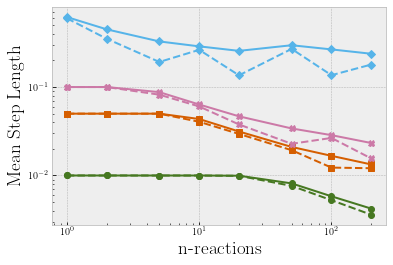

In [330]:
legend = []
marker_idx=0
for m in sorted(time_step_mean_std.keys()):
    if not "CBSA" in m: continue
    values_mean = []
    values_abs = []
    x = sorted(time_step_mean_std[m].keys())
    y = [time_step_mean_std[m][n][0] for n in x]
    yerr = [time_step_mean_std[m][n][1] for n in x]
    
    lstyle = "-"
    label = m
    if "alpha" in m:
        lstyle = "--"
        label=None
        marker_idx-=1
    
    plt.errorbar(x,y,label=label,marker=markers[marker_idx],color=colors[marker_idx+3],linestyle=lstyle)
    marker_idx+=1

plt.xlabel("n-reactions",fontsize=19)
plt.ylabel("Mean Step Length",fontsize=19)
plt.xscale('log')
plt.yscale('log')
    
#plt.legend()
plt.savefig("n-reactions_mean_step.png",dpi=300, bbox_inches='tight')

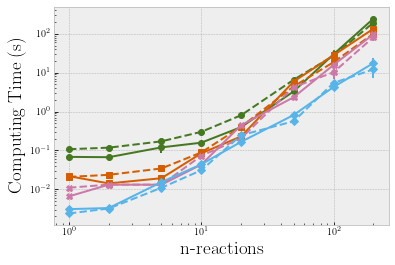

In [331]:
legend = []
marker_idx=0
for m in sorted(computing_times_mean_std.keys()):
    if not "CBSA" in m: continue
    values_mean = []
    values_abs = []
    x = sorted(computing_times_mean_std[m].keys())
    y = [computing_times_mean_std[m][n][0] for n in x]
    yerr = [computing_times_mean_std[m][n][1] for n in x]
    
    lstyle = "-"
    label = m
    if "alpha" in m:
        lstyle = "--"
        label=None
        marker_idx-=1
    
    plt.errorbar(x,y,yerr=yerr,label=label,marker=markers[marker_idx],color=colors[marker_idx+3],linestyle=lstyle)
    marker_idx+=1

plt.xlabel("n-reactions",fontsize=19)
plt.ylabel("Computing Time (s)",fontsize=19)
plt.xscale('log')
plt.yscale('log')
    
#plt.legend()
plt.savefig("n-reactions_computing_time.png",dpi=300, bbox_inches='tight')


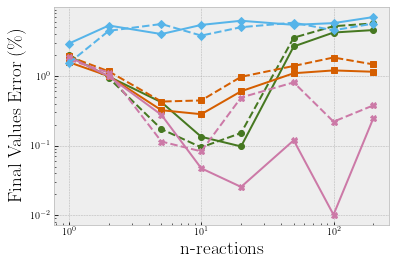

In [332]:
legend = []
marker_idx=0
for m in sorted(last_values_mean_std_theoretical.keys()):
    if not "CBSA" in m: continue
    values_mean = []
    values_abs = []
    x = sorted(last_values_mean_std_theoretical[m].keys())
    y = np.array([last_values_mean_std_theoretical[m][n][0] for n in x])
    theoretical = np.array([last_values_mean_std_theoretical[m][n][2] for n in x])
    error = np.abs((y/theoretical)-1)*100
    
    lstyle = "-"
    label = m
    if "alpha" in m:
        lstyle = "--"
        label=None
        marker_idx-=1
    
    plt.errorbar(x,error,label=label,marker=markers[marker_idx],color=colors[marker_idx+3],linestyle=lstyle)
    marker_idx+=1

plt.xlabel("n-reactions",fontsize=19)
plt.ylabel("Final Values Error (\%)",fontsize=19)
plt.xscale('log')
plt.yscale('log')
    
#plt.legend()
plt.savefig("n-reactions_x_error.png",dpi=300, bbox_inches='tight')



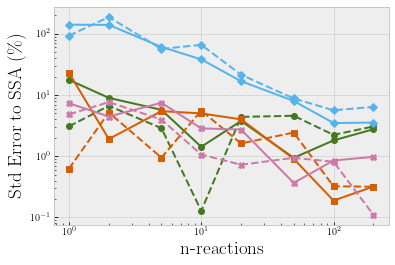

In [333]:
legend = []
marker_idx=0
for m in sorted(last_values_mean_std_theoretical.keys()):
    if not "CBSA" in m: continue
    values_mean = []
    values_abs = []
    x = sorted(last_values_mean_std_theoretical[m].keys())
    y = np.array([last_values_mean_std_theoretical[m][n][1] for n in x])
    theoretical = np.array([last_values_mean_std_theoretical["StochPy SSA"][n][1] for n in x])
    error = np.abs((y/theoretical)-1)*100
    
    lstyle = "-"
    label = m
    if "alpha" in m:
        lstyle = "--"
        label=None
        marker_idx-=1
    
    plt.errorbar(x,error,label=label,marker=markers[marker_idx],color=colors[marker_idx+3],linestyle=lstyle)
    marker_idx+=1

plt.xlabel("n-reactions",fontsize=19)
plt.ylabel("Std Error to SSA (\%)",fontsize=19)
plt.xscale('log')
plt.yscale('log')
    
#plt.legend()
plt.savefig("n-reactions_std_error.png",dpi=300, bbox_inches='tight')


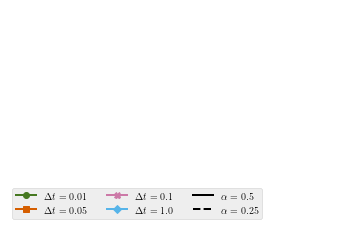

In [320]:
f = lambda m,c,l: plt.plot([],[],marker=m, color=c,linestyle=l)[0]
handles_dt = [f(markers[m], colors[m+3],'-') for m in range(4)]
handles_alpha = [f('', 'black','-'),f('', 'black','--')]
labels = [r'$\Delta t = 0.01$',r'$\Delta t = 0.05$',r'$\Delta t = 0.1$',r'$\Delta t = 1.0$',r'$\alpha = 0.5$',r'$\alpha = 0.25$']
legend = plt.legend(handles_dt+handles_alpha, labels, loc=3,ncol=3, framealpha=1, frameon=True)

def export_legend(legend, filename="legend.png", expand=[-5,-5,5,5]):
    fig  = legend.figure
    fig.canvas.draw()
    bbox  = legend.get_window_extent()
    bbox = bbox.from_extents(*(bbox.extents + np.array(expand)))
    bbox = bbox.transformed(fig.dpi_scale_trans.inverted())
    fig.savefig(filename, dpi=300, bbox_inches=bbox,transparent=True)

plt.box(on=None)
plt.grid(False, which='major', axis='both')
plt.tick_params(axis='both', length = 0)
plt.xticks([])
plt.yticks([])
export_legend(legend,filename="n-reactions_legend.png")
plt.show()

In [90]:
np.log(0.00624943/0.1)/np.log(0.5)

4.000131579787859

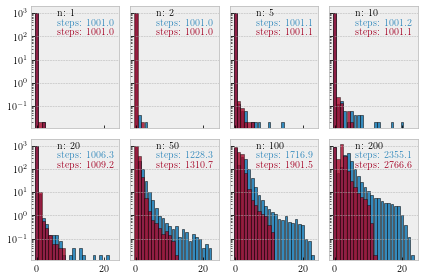

In [305]:
methods = ["CBSA dt 0.01"]
cbsa_infos = []
for m in methods:
    for n in n_reactions:
        cbsa_infos.append([m,replicates,(n,k0,k1,total_sim_time)])
cbsa_timesteps_count_alpha_05 = get_measure(cbsa_infos,k0,k1,cbsa_iterations,max_dt=float(m.split(" ")[2]),alpha=0.5)[methods[0]]

methods = ["CBSA dt 0.01 alpha 0.25"]
cbsa_infos = []
for m in methods:
    for n in n_reactions:
        cbsa_infos.append([m,replicates,(n,k0,k1,total_sim_time)])
cbsa_timesteps_count_alpha_025 = get_measure(cbsa_infos,k0,k1,cbsa_iterations,max_dt=float(m.split(" ")[2]),alpha=0.25)[methods[0]]

lines = 2
cols = 4

fig, axs = plt.subplots(lines, cols,tight_layout=True,sharex=True,sharey=True)

n_reactions = sorted(cbsa_timesteps_count_alpha_05.keys())
for i in range(lines):
    for j in range(cols):
        pos = i*cols + j
        freq = cbsa_timesteps_count_alpha_05[n_reactions[pos]]
        x1 = sorted(freq.keys())
        y1 = [freq[n] for n in x1]
        axs[i,j].bar(x1,y1,width=0.8, edgecolor="black", align="center",label="alpha 0.5")
        
        freq = cbsa_timesteps_count_alpha_025[n_reactions[pos]]
        x2 = sorted(freq.keys())
        y2 = [freq[n] for n in x2]
        axs[i,j].bar(x2,y2,width=1., edgecolor="black", align="center",label="alpha 0.25",alpha=0.8)
        
        axs[i,j].text(6,800,'n: '+str(n_reactions[pos]))
        axs[i,j].text(6,300,'steps: '+str(np.round(np.sum(y1),1)),color=colors[0])
        axs[i,j].text(6,120,'steps: '+str(np.round(np.sum(y2),1)),color=colors[1])
        
        axs[i,j].grid(False,axis="x")
        axs[i,j].set_yscale("log")
        axs[i,j].set_xlim(-1.695, 24.595000000000002)
        axs[i,j].set_ylim(0.011576652945533257, 1938.2804430237165)
        
plt.savefig("n-reactions_steps_dt_0.01.png",dpi=300, bbox_inches='tight')

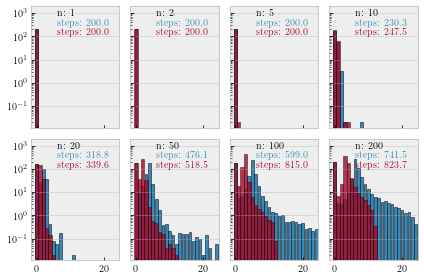

In [306]:
methods = ["CBSA dt 0.05"]
cbsa_infos = []
for m in methods:
    for n in n_reactions:
        cbsa_infos.append([m,replicates,(n,k0,k1,total_sim_time)])
cbsa_timesteps_count_alpha_05 = get_measure(cbsa_infos,k0,k1,cbsa_iterations,max_dt=float(m.split(" ")[2]),alpha=0.5)[methods[0]]

methods = ["CBSA dt 0.05 alpha 0.25"]
cbsa_infos = []
for m in methods:
    for n in n_reactions:
        cbsa_infos.append([m,replicates,(n,k0,k1,total_sim_time)])
cbsa_timesteps_count_alpha_025 = get_measure(cbsa_infos,k0,k1,cbsa_iterations,max_dt=float(m.split(" ")[2]),alpha=0.25)[methods[0]]

lines = 2
cols = 4

fig, axs = plt.subplots(lines, cols,tight_layout=True,sharex=True,sharey=True)

n_reactions = sorted(cbsa_timesteps_count_alpha_05.keys())
for i in range(lines):
    for j in range(cols):
        pos = i*cols + j
        freq = cbsa_timesteps_count_alpha_05[n_reactions[pos]]
        x1 = sorted(freq.keys())
        y1 = [freq[n] for n in x1]
        axs[i,j].bar(x1,y1,width=0.8, edgecolor="black", align="center",label="alpha 0.5")
        
        freq = cbsa_timesteps_count_alpha_025[n_reactions[pos]]
        x2 = sorted(freq.keys())
        y2 = [freq[n] for n in x2]
        axs[i,j].bar(x2,y2,width=1., edgecolor="black", align="center",label="alpha 0.25",alpha=0.8)
        
        axs[i,j].text(6,800,'n: '+str(n_reactions[pos]))
        axs[i,j].text(6,300,'steps: '+str(np.round(np.sum(y1),1)),color=colors[0])
        axs[i,j].text(6,120,'steps: '+str(np.round(np.sum(y2),1)),color=colors[1])
        
        axs[i,j].grid(False,axis="x")
        axs[i,j].set_yscale("log")
        axs[i,j].set_xlim(-1.695, 24.595000000000002)
        axs[i,j].set_ylim(0.011576652945533257, 1938.2804430237165)

plt.savefig("n-reactions_steps_dt_0.05.png",dpi=300, bbox_inches='tight')


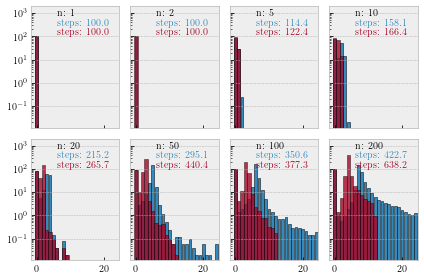

In [307]:
methods = ["CBSA dt 0.1"]
cbsa_infos = []
for m in methods:
    for n in n_reactions:
        cbsa_infos.append([m,replicates,(n,k0,k1,total_sim_time)])
cbsa_timesteps_count_alpha_05 = get_measure(cbsa_infos,k0,k1,cbsa_iterations,max_dt=float(m.split(" ")[2]),alpha=0.5)[methods[0]]

methods = ["CBSA dt 0.1 alpha 0.25"]
cbsa_infos = []
for m in methods:
    for n in n_reactions:
        cbsa_infos.append([m,replicates,(n,k0,k1,total_sim_time)])
cbsa_timesteps_count_alpha_025 = get_measure(cbsa_infos,k0,k1,cbsa_iterations,max_dt=float(m.split(" ")[2]),alpha=0.25)[methods[0]]

lines = 2
cols = 4

fig, axs = plt.subplots(lines, cols,tight_layout=True,sharex=True,sharey=True)

n_reactions = sorted(cbsa_timesteps_count_alpha_05.keys())
for i in range(lines):
    for j in range(cols):
        pos = i*cols + j
        freq = cbsa_timesteps_count_alpha_05[n_reactions[pos]]
        x1 = sorted(freq.keys())
        y1 = [freq[n] for n in x1]
        axs[i,j].bar(x1,y1,width=0.8, edgecolor="black", align="center",label="alpha 0.5")
        
        freq = cbsa_timesteps_count_alpha_025[n_reactions[pos]]
        x2 = sorted(freq.keys())
        y2 = [freq[n] for n in x2]
        axs[i,j].bar(x2,y2,width=1., edgecolor="black", align="center",label="alpha 0.25",alpha=0.8)
        
        axs[i,j].text(6,800,'n: '+str(n_reactions[pos]))
        axs[i,j].text(6,300,'steps: '+str(np.round(np.sum(y1),1)),color=colors[0])
        axs[i,j].text(6,120,'steps: '+str(np.round(np.sum(y2),1)),color=colors[1])
        
        axs[i,j].grid(False,axis="x")
        axs[i,j].set_yscale("log")
        axs[i,j].set_xlim(-1.695, 24.595000000000002)
        axs[i,j].set_ylim(0.011576652945533257, 1938.2804430237165)
plt.savefig("n-reactions_steps_dt_0.1.png",dpi=300, bbox_inches='tight')

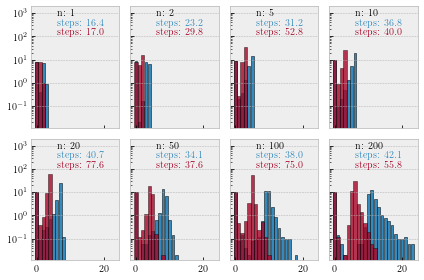

In [308]:
methods = ["CBSA dt 1.0"]
cbsa_infos = []
for m in methods:
    for n in n_reactions:
        cbsa_infos.append([m,replicates,(n,k0,k1,total_sim_time)])
cbsa_timesteps_count_alpha_05 = get_measure(cbsa_infos,k0,k1,cbsa_iterations,max_dt=float(m.split(" ")[2]),alpha=0.5)[methods[0]]

methods = ["CBSA dt 1.0 alpha 0.25"]
cbsa_infos = []
for m in methods:
    for n in n_reactions:
        cbsa_infos.append([m,replicates,(n,k0,k1,total_sim_time)])
cbsa_timesteps_count_alpha_025 = get_measure(cbsa_infos,k0,k1,cbsa_iterations,max_dt=float(m.split(" ")[2]),alpha=0.25)[methods[0]]

lines = 2
cols = 4

fig, axs = plt.subplots(lines, cols,tight_layout=True,sharex=True,sharey=True)

n_reactions = sorted(cbsa_timesteps_count_alpha_05.keys())
for i in range(lines):
    for j in range(cols):
        pos = i*cols + j
        freq = cbsa_timesteps_count_alpha_05[n_reactions[pos]]
        x1 = sorted(freq.keys())
        y1 = [freq[n] for n in x1]
        axs[i,j].bar(x1,y1,width=0.8, edgecolor="black", align="center",label="alpha 0.5")
        
        freq = cbsa_timesteps_count_alpha_025[n_reactions[pos]]
        x2 = sorted(freq.keys())
        y2 = [freq[n] for n in x2]
        axs[i,j].bar(x2,y2,width=1., edgecolor="black", align="center",label="alpha 0.25",alpha=0.8)
        
        axs[i,j].text(6,800,'n: '+str(n_reactions[pos]))
        axs[i,j].text(6,300,'steps: '+str(np.round(np.sum(y1),1)),color=colors[0])
        axs[i,j].text(6,120,'steps: '+str(np.round(np.sum(y2),1)),color=colors[1])
        
        axs[i,j].grid(False,axis="x")
        axs[i,j].set_yscale("log")
        axs[i,j].set_xlim(-1.695, 24.595000000000002)
        axs[i,j].set_ylim(0.011576652945533257, 1938.2804430237165)
plt.savefig("n-reactions_steps_dt_1.0.png",dpi=300, bbox_inches='tight')

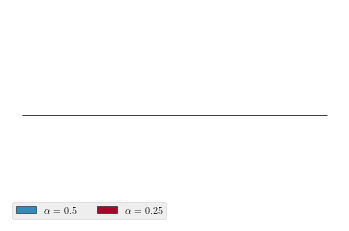

In [319]:
f = lambda w: plt.bar([0],[0],width=0.8, edgecolor="black")[0]
handles = [f('-') for m in range(2)]
labels = [r'$\alpha = 0.5$',r'$\alpha = 0.25$']
legend = plt.legend(handles, labels, loc=3,ncol=2, framealpha=1, frameon=True)

def export_legend(legend, filename="legend.png", expand=[-5,-5,5,5]):
    fig  = legend.figure
    fig.canvas.draw()
    bbox  = legend.get_window_extent()
    bbox = bbox.from_extents(*(bbox.extents + np.array(expand)))
    bbox = bbox.transformed(fig.dpi_scale_trans.inverted())
    fig.savefig(filename, dpi=300, bbox_inches=bbox,transparent=True)

plt.box(on=None)
plt.grid(False, which='major', axis='both')
plt.tick_params(axis='both', length = 0)
plt.xticks([])
plt.yticks([])
export_legend(legend,filename="n-reactions_steps_legend.png")
plt.show()